# Model - Multivariate 1-step LSTM Models

## All changes

In [1]:
name_of_data = 'Stock_Data.csv'

## Libs

In [2]:
# all packages
import numpy as np
import pandas as pd
from numpy import array
from numpy import hstack
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data *.csv

<TICKER>      object
<FIRST>        int64
<HIGH>         int64
<LOW>          int64
<CLOSE>        int64
<VALUE>      float64
<VOL>          int64
<OPENINT>      int64
<PER>         object
<OPEN>         int64
<LAST>         int64
dtype: object


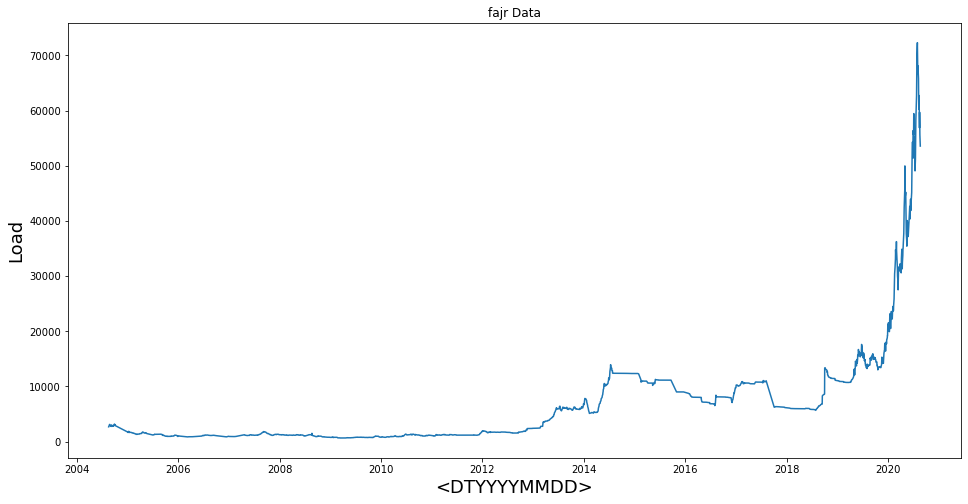

                     <TICKER>  <FIRST>  <HIGH>  <LOW>  <CLOSE>       <VALUE>  \
<DTYYYYMMDD>                                                                   
2004-08-16    Amirkabir.Steel     2732    2732   2601     2678  4.426716e+09   
2004-08-18    Amirkabir.Steel     2811    2811   2811     2811  1.172187e+09   
2004-08-21    Amirkabir.Steel     2951    2951   2951     2951  5.016700e+09   
2004-08-22    Amirkabir.Steel     3098    3098   3000     3097  2.461034e+10   
2004-08-23    Amirkabir.Steel     3097    3250   3070     3101  6.107483e+09   
...                       ...      ...     ...    ...      ...           ...   
2020-08-16    Amirkabir.Steel    56770   59600  56700    56860  1.770000e+11   
2020-08-17    Amirkabir.Steel    59700   59700  58160    59690  5.010000e+11   
2020-08-18    Amirkabir.Steel    61000   61000  56710    57340  1.600000e+11   
2020-08-19    Amirkabir.Steel    54480   54480  54480    55620  2.611079e+10   
2020-08-22    Amirkabir.Steel    57640  

In [3]:
# load data + set time
data = pd.read_csv(name_of_data, index_col='<DTYYYYMMDD>', parse_dates=True)
data = data.sort_values('<DTYYYYMMDD>',ascending=True)
print(data.dtypes)

plt.figure(figsize=(16, 8))
plt.title('fajr Data')
plt.plot(data['<CLOSE>'])
plt.xlabel('<DTYYYYMMDD>', fontsize=18)
plt.ylabel('Load', fontsize=18)
plt.show()

print(data)

In [4]:
# define train and test data set
data_train = data.loc[:"2020-02-12", :]
data_test = data.loc["2020-02-12": , :]

In [5]:
# define scaler for Normalize Data
scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))

In [6]:
x_train = array(scaler.fit_transform(data_train[['<HIGH>', '<LOW>', '<VALUE>', '<VOL>']]))
x_test = array(scaler.fit_transform(data_test[['<HIGH>', '<LOW>', '<VALUE>', '<VOL>']]))
y_train = array(scaler.fit_transform(data_train[['<CLOSE>']]))
y_test = array(scaler.fit_transform(data_test[['<CLOSE>']]))
n_features = 4

In [7]:
# convert to [rows, columns] structure
x_train = x_train.reshape((len(x_train), n_features))
x_test = x_test.reshape((len(x_test), n_features))
y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))

# horizontally stack columns
dataset_train = hstack((x_train, y_train))
dataset_test = hstack((x_test, y_test))

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [9]:
# choose a number of time steps / features
n_steps_in, n_steps_out = 60, 1

# convert into input/output
X_train, y_train = split_sequences(dataset_train, n_steps_in, n_steps_out)
X_test, y_test = split_sequences(dataset_test, n_steps_in, n_steps_out)

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [10]:
# define model
model = Sequential()
model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(n_steps_in,
n_features)))
model.add(Dropout(0.2))

model.add(LSTM(units = 256, return_sequences = True))
model.add(Dropout(0.1))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.1))

model.add((Dense(units = 128, activation='relu')))
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
# fit model
model.fit(X_train, y_train, epochs=100, batch_size = 64, verbose=1)

Epoch 1/5
40/40 [==============================] - 15s 370ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 2/5
40/40 [==============================] - 14s 349ms/step - loss: 9.0343e-04 - mean_squared_error: 9.0343e-04
Epoch 3/5
40/40 [==============================] - 15s 374ms/step - loss: 7.8382e-04 - mean_squared_error: 7.8382e-04
Epoch 4/5
40/40 [==============================] - 17s 413ms/step - loss: 6.7890e-04 - mean_squared_error: 6.7890e-04
Epoch 5/5
40/40 [==============================] - 14s 360ms/step - loss: 6.4681e-04 - mean_squared_error: 6.4681e-04


## Prediction on test Data

In [11]:
# use trained model to predict test data
y_test_hat = model.predict(X_test, verbose=0)
# inverse transform
inverse_y_test = scaler.inverse_transform(y_test)
inverse_y_test_hat = scaler.inverse_transform(y_test_hat)
print("Prediction of close price for test data: ", inverse_y_test_hat)

Prediction of close price for test data:  [[47090.76 ]
 [46490.06 ]
 [45774.582]
 [45108.9  ]
 [44505.527]
 [43922.58 ]
 [43362.92 ]
 [42866.656]
 [42538.773]
 [42397.094]
 [42369.785]
 [42426.387]
 [42578.66 ]
 [42815.055]
 [43099.254]
 [43441.066]
 [43845.33 ]
 [44333.938]
 [44837.594]
 [45352.44 ]
 [45948.406]
 [46637.71 ]
 [47481.426]
 [48423.617]
 [49391.74 ]
 [50366.77 ]
 [51377.17 ]
 [52410.574]
 [53427.75 ]
 [54425.113]
 [55307.38 ]
 [56012.78 ]
 [56564.85 ]
 [56993.562]
 [57297.297]
 [57433.46 ]
 [57327.473]
 [57059.836]
 [56760.32 ]
 [56550.215]
 [56525.375]
 [56773.484]
 [57280.7  ]
 [58162.41 ]
 [59296.668]
 [60603.996]
 [61919.383]
 [63131.527]
 [64179.223]
 [65077.773]
 [65818.23 ]
 [66281.45 ]
 [66458.43 ]
 [66363.14 ]
 [66013.19 ]
 [65563.8  ]
 [64996.56 ]
 [64225.88 ]
 [63326.523]]


## Plot + save Model

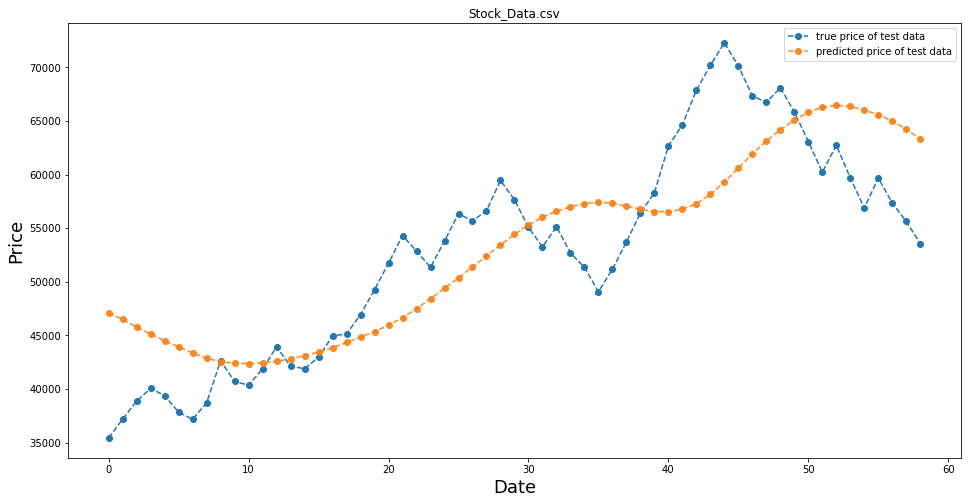

In [12]:
plt.figure(figsize=(16, 8))
plt.title(name_of_data)
plt.plot(inverse_y_test, 'o--', alpha=1)
plt.plot(inverse_y_test_hat, 'o--', alpha=0.9)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(['true price of test data', 'predicted price of test data'], loc='upper right')
plt.show()

## Visulaize MOdel